In [78]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.set_option("display.max_rows", 500)


In [82]:
tb_housing['SalePrice']

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [83]:
tb_housing = pd.read_csv("data/tb_ames_housing.csv")
tb_housing = tb_housing.dropna(axis=1, thresh=tb_housing.shape[0] * 0.5)

X_full = tb_housing.drop('SalePrice', axis = 1)
y_full = tb_housing['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full)
tb_housing_cat = X_train.select_dtypes(exclude="number")


# Treatment of Categorical Variables

## Dealing with rare & missing levels

In [39]:
nl_list = []
mcl_list = []
lcl_list = []
na_list = []
column_list = []
for column in tb_housing_cat.columns:
    num_levels = len(tb_housing_cat[column].unique())
    most_common_level = tb_housing_cat[column].value_counts().max()
    least_common_level = tb_housing_cat[column].value_counts().min()
    num_non_na = (~tb_housing_cat[column].isna()).sum()
    column_list.append(column)
    nl_list.append(num_levels)
    mcl_list.append(most_common_level)
    lcl_list.append(least_common_level)
    na_list.append(num_non_na)

tb_cat_info = pd.DataFrame(
    {
        "column": column_list,
        "num_levels": nl_list,
        "most_common_level": mcl_list,
        "least_common_level": lcl_list,
        "num_nonna": na_list,
    }
)
tb_cat_info


,column,num_levels,most_common_level,least_common_level,num_nonna
0,MSZoning,5,1151,10,1460
1,Street,2,1454,6,1460
2,LotShape,4,925,10,1460
3,LandContour,4,1311,36,1460
4,Utilities,2,1459,1,1460
5,LotConfig,5,1052,4,1460
6,LandSlope,3,1382,13,1460
7,Neighborhood,25,225,2,1460
8,Condition1,9,1260,2,1460
9,Condition2,8,1445,1,1460


In [40]:
big_level_thresh = (tb_cat_info['most_common_level']/tb_cat_info['num_nonna']) < 0.9
tb_cat_info = tb_cat_info[big_level_thresh].copy()
tb_cat_info

,column,num_levels,most_common_level,least_common_level,num_nonna
0,MSZoning,5,1151,10,1460
2,LotShape,4,925,10,1460
3,LandContour,4,1311,36,1460
5,LotConfig,5,1052,4,1460
7,Neighborhood,25,225,2,1460
8,Condition1,9,1260,2,1460
10,BldgType,5,1220,31,1460
11,HouseStyle,8,726,8,1460
12,RoofStyle,6,1141,2,1460
14,Exterior1st,15,515,1,1460


In [41]:
tb_cat_levels = pd.DataFrame()
for column in tb_housing_cat.columns:
    num_obs_level = tb_housing_cat[column].value_counts().reset_index()
    num_obs_level.columns = ['level_name', 'num_obs']
    num_obs_level['column'] = column
    tb_cat_levels = pd.concat([tb_cat_levels, num_obs_level], axis = 0)

tb_cat_levels.head(10)

,level_name,num_obs,column
0,RL,1151,MSZoning
1,RM,218,MSZoning
2,FV,65,MSZoning
3,RH,16,MSZoning
4,C (all),10,MSZoning
0,Pave,1454,Street
1,Grvl,6,Street
0,Reg,925,LotShape
1,IR1,484,LotShape
2,IR2,41,LotShape


In [42]:
tb_cat_level_info = tb_cat_info.merge(tb_cat_levels, on = 'column')
tb_cat_level_info.head()

,column,num_levels,most_common_level,least_common_level,num_nonna,level_name,num_obs
0,MSZoning,5,1151,10,1460,RL,1151
1,MSZoning,5,1151,10,1460,RM,218
2,MSZoning,5,1151,10,1460,FV,65
3,MSZoning,5,1151,10,1460,RH,16
4,MSZoning,5,1151,10,1460,C (all),10


In [45]:

tb_cat_level_info.loc[tb_cat_level_info['num_obs'] > 50, 'grp_level'] = tb_cat_level_info['level_name']
tb_cat_level_info.loc[tb_cat_level_info['num_obs'] <= 50, 'grp_level'] = "Others"
tb_cat_level_info.head(20)

,column,num_levels,most_common_level,least_common_level,num_nonna,level_name,num_obs,per_nonna_obs,grp_level
0,MSZoning,5,1151,10,1460,RL,1151,0.788356,RL
1,MSZoning,5,1151,10,1460,RM,218,0.149315,RM
2,MSZoning,5,1151,10,1460,FV,65,0.044521,FV
3,MSZoning,5,1151,10,1460,RH,16,0.010959,Others
4,MSZoning,5,1151,10,1460,C (all),10,0.006849,Others
5,LotShape,4,925,10,1460,Reg,925,0.633562,Reg
6,LotShape,4,925,10,1460,IR1,484,0.331507,IR1
7,LotShape,4,925,10,1460,IR2,41,0.028082,Others
8,LotShape,4,925,10,1460,IR3,10,0.006849,Others
9,LandContour,4,1311,36,1460,Lvl,1311,0.897945,Lvl


In [46]:
tb_cat_level_info.shape

(179, 9)

In [50]:
tb_cat_level_info.groupby(['column', 'grp_level'])['level_name'].count().reset_index()

(113, 3)

In [60]:
for column in tb_cat_level_info['column'].unique():
    tb_column = tb_cat_level_info[tb_cat_level_info['column'] == column]
    grp_dict = dict()

    for level in tb_column['level_name'].unique():
        grp_dict[level] = tb_column.loc[tb_column['level_name'] == level, 'grp_level'].item()

    new_column = 'grp_' + column
    X_train[new_column] = X_train[column].map(grp_dict).fillna('Others')

### Writing a wrapper

In [ ]:
def create_group_dict(categorical_data, mcl_level = 0.9, min_obs = 50):
    # Creating measurements of categorical data quality
    nl_list = []
    mcl_list = []
    lcl_list = []
    na_list = []
    column_list = []
    for column in categorical_data.columns:
        num_levels = len(categorical_data[column].unique())
        most_common_level = categorical_data[column].value_counts().max()
        least_common_level = categorical_data[column].value_counts().min()
        num_non_na = (~categorical_data[column].isna()).sum()
        column_list.append(column)
        nl_list.append(num_levels)
        mcl_list.append(most_common_level)
        lcl_list.append(least_common_level)
        na_list.append(num_non_na)
    tb_cat_info = pd.DataFrame(
        {
            "column": column_list,
            "num_levels": nl_list,
            "most_common_level": mcl_list,
            "least_common_level": lcl_list,
            "num_nonna": na_list,
        }
    )
    # Filtering columns with low variance (most values are the same)
    big_level_thresh = (tb_cat_info['most_common_level']/tb_cat_info['num_nonna']) < mcl_level
    tb_cat_info = tb_cat_info[big_level_thresh].copy()

    tb_cat_levels = pd.DataFrame()
    for column in categorical_data.columns:
        num_obs_level = categorical_data[column].value_counts().reset_index()
        num_obs_level.columns = ['level_name', 'num_obs']
        num_obs_level['column'] = column
        tb_cat_levels = pd.concat([tb_cat_levels, num_obs_level], axis = 0)

    tb_cat_level_info = tb_cat_info.merge(tb_cat_levels, on = 'column')
    tb_cat_level_info.loc[tb_cat_level_info['num_obs'] > min_obs, 'grp_level'] = tb_cat_level_info['level_name']
    tb_cat_level_info.loc[tb_cat_level_info['num_obs'] <= min_obs, 'grp_level'] = "Others"
    column_grp_dict = dict()
    for column in tb_cat_level_info['column'].unique():
        tb_column = tb_cat_level_info[tb_cat_level_info['column'] == column]
        grp_dict = dict()

        for level in tb_column['level_name'].unique():
            grp_dict[level] = tb_column.loc[tb_column['level_name'] == level, 'grp_level'].item()

        column_grp_dict[column] = grp_dict

In [62]:
tb_housing_clean_cat = tb_housing.filter(regex = 'grp_', axis = 1).copy()

,grp_MSZoning,grp_LotShape,grp_LandContour,grp_LotConfig,grp_Neighborhood,grp_Condition1,grp_BldgType,grp_HouseStyle,grp_RoofStyle,grp_Exterior1st,...,grp_BsmtExposure,grp_BsmtFinType1,grp_BsmtFinType2,grp_HeatingQC,grp_KitchenQual,grp_FireplaceQu,grp_GarageType,grp_GarageFinish,grp_SaleType,grp_SaleCondition
0,RL,Reg,Lvl,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,...,No,GLQ,Unf,Ex,Gd,Others,Attchd,RFn,WD,Normal
1,RL,Reg,Lvl,Others,Others,Feedr,1Fam,1Story,Gable,MetalSd,...,Gd,ALQ,Unf,Ex,TA,TA,Attchd,RFn,WD,Normal
2,RL,IR1,Lvl,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,...,Mn,GLQ,Unf,Ex,Gd,TA,Attchd,RFn,WD,Normal
3,RL,IR1,Lvl,Corner,Crawfor,Norm,1Fam,2Story,Gable,Wd Sdng,...,No,ALQ,Unf,Gd,Gd,Gd,Detchd,Unf,WD,Abnorml
4,RL,IR1,Lvl,Others,Others,Norm,1Fam,2Story,Gable,VinylSd,...,Av,GLQ,Unf,Ex,Gd,TA,Attchd,RFn,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Reg,Lvl,Inside,Gilbert,Norm,1Fam,2Story,Gable,VinylSd,...,No,Unf,Unf,Ex,TA,TA,Attchd,RFn,WD,Normal
1456,RL,Reg,Lvl,Inside,NWAmes,Norm,1Fam,1Story,Gable,Plywood,...,No,ALQ,Rec,TA,TA,TA,Attchd,Unf,WD,Normal
1457,RL,Reg,Lvl,Inside,Crawfor,Norm,1Fam,2Story,Gable,CemntBd,...,No,GLQ,Unf,Ex,Gd,Gd,Attchd,RFn,WD,Normal
1458,RL,Reg,Lvl,Inside,NAmes,Norm,1Fam,1Story,Hip,MetalSd,...,Mn,GLQ,Rec,Gd,Gd,Others,Attchd,Unf,WD,Normal


# Complex Encoding Strategies

## Choosing categorical levels

In [65]:
from sklearn.feature_selection import mutual_info_regression
# You can also use mutual_info_classif for classification problems

In [66]:
X = pd.get_dummies(tb_housing_clean_cat)
y = tb_housing['SalePrice']

mir_fit = mutual_info_regression(X, y, discrete_features=True)

In [76]:
np.quantile(mir_fit, 0.75)

0.06711260719069573

## MCA

In [ ]:
!pip install prince

In [2]:
import prince


In [15]:
mca_fit = prince.MCA(n_components=2)
mca_fit.fit(tb_housing_cat)


MCA()

<AxesSubplot:title={'center':'Row and column principal coordinates'}, xlabel='Component 0 (4.36% inertia)', ylabel='Component 1 (2.62% inertia)'>

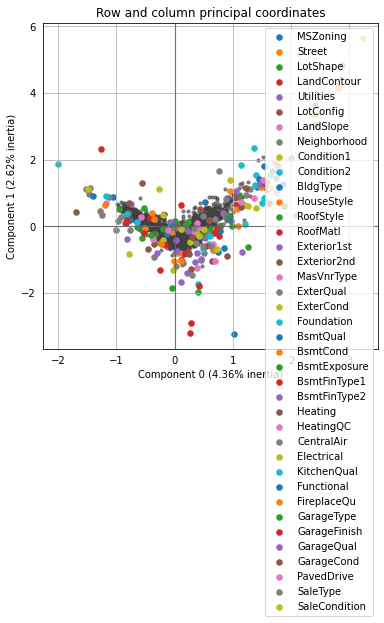

In [17]:
mca_fit.plot_coordinates(tb_housing_cat)
